In this case we will try to run more epochs in this model hoping that we could get a better result using this model.

# Preparation for the model

In [ ]:
%%capture
!pip install pytorch_lightning optuna

In [ ]:
#@title Importing the modules
from google.colab import drive
import os
import torch
drive.mount('/content/drive')

enable_code_paths = True
enable_block = False

if enable_code_paths:
    URL_path = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/clean_dataset.csv"
    URL_synthetic_data = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/synthetic_data.csv"
    URL_path_save = "/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model"
    URL_helper ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/helper/"
    URL_hyperparameters ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/hyperparameters/"
    URL_test_labels ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/test_labels.csv"
    URL_test ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/dataset/test.csv"
    URL_model_saved ="/content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model/017_model"
else :
    URL_path = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
    URL_path_save = "/content/drive/MyDrive/turing_college_experiments/14_NLP/model"
    URL_helper = "/content/drive/MyDrive/turing_college_experiments/14_NLP/helper"
import sys
sys.path.append(URL_helper)

from colab_helper import proportion_balance_classes

"""
Verify the cores and gpu in the colab
"""
num_cores = os.cpu_count()  # Get the number of CPU cores
print(f'Number of available CPU cores: {num_cores}')
num_workers_colab = num_cores - 1
print(f'Setting num_workers to: {num_workers_colab}')

num_gpus_colab = torch.cuda.device_count()
gpu_list = [torch.cuda.get_device_name(i) for i in range(num_gpus_colab)]
num_gpus_colab, gpu_list


"""
import the modules and configuration colors
"""
## Core Libraries
import os
import time
import math
import numpy as np
import pandas as pd

# Sklearn for Evaluation Metrics and Model Selection
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, recall_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split

# PyTorch Libraries and Lightning
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import pytorch_lightning as pl

# Hugging Face Transformers
from transformers import (
    AutoTokenizer, AutoModel,
    get_linear_schedule_with_warmup
)

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Progress Bar
from tqdm import tqdm

# Hyperparameter Tuning
import optuna
import joblib

# Google Colab (if applicable)
from google.colab import drive

# TorchMetrics (for AUROC calculation)
from torchmetrics.functional.classification import auroc

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

"""
Colorama
"""
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)
theme_color

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of available CPU cores: 8
Setting num_workers to: 7


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

We will be exploring the Roberta model and see if we could find any good performance

In [ ]:
#@title Preprocesing the dataset
dataframe = pd.read_csv(URL_path)
dataframe_test_import = pd.read_csv(URL_test)
dataframe_test_labels = pd.read_csv(URL_test_labels)
print(dataframe.head())

"""
Test dataset preparation
"""
attributes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
new_attributes = attributes + ["non_toxic"]

dataframe_test_labels_filtered = dataframe_test_labels.loc[dataframe_test_labels[attributes].sum(axis=1) >= 0]
dataframe_test_labels_filtered.shape
dataframe_test = dataframe_test_labels_filtered.merge(dataframe_test_import, on='id')
dataframe_test = dataframe_test.drop(columns=["id"])
print(dataframe_test.shape)
print("dataframe_test")
print(dataframe_test.head())

                                        comment_text  toxic  severe_toxic  \
0  ExplanationWhy the edits made under my usernam...      0             0   
1  D'aww! He matches this background colour I'm s...      0             0   
2  Hey man, I'm really not trying to edit war. It...      0             0   
3  "MoreI can't make any real suggestions on impr...      0             0   
4  You, sir, are my hero. Any chance you remember...      0             0   

   obscene  threat  insult  identity_hate  
0        0       0       0              0  
1        0       0       0              0  
2        0       0       0              0  
3        0       0       0              0  
4        0       0       0              0  
(63978, 7)
dataframe_test
   toxic  severe_toxic  obscene  threat  insult  identity_hate  \
0      0             0        0       0       0              0   
1      0             0        0       0       0              0   
2      0             0        0       0       0  

Now we will split the dataset to understand whats happening

In [ ]:
# Use the attributes list in the condition
dataframe["non_toxic"] = np.where(dataframe[attributes].any(axis=1), 0, 1)
dataframe.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,ExplanationWhy the edits made under my usernam...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""MoreI can't make any real suggestions on impr...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [ ]:
#@title Split the dataset
# drop the non toxic column
dataframe.drop(columns= ["non_toxic"], inplace= True)

# sample sisze
SAMPLE_PERCENTAGE = 1 #@param
dataframe_clean=dataframe.sample(frac=SAMPLE_PERCENTAGE,random_state=42)

# split
train_size = 0.8 #@param
train_dataset=dataframe_clean.sample(frac=train_size,random_state=42)
validation_dataset=dataframe_clean.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(dataframe_clean.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(validation_dataset.shape))

FULL Dataset: (144790, 7)
TRAIN Dataset: (115832, 7)
TEST Dataset: (28958, 7)


In [ ]:
#@title Add syntetic data and resampling
dataframe_syn = pd.read_csv(URL_synthetic_data)
# dataframe_syn = dataframe_syn.rename(columns={'comment_text': 'text'})
dataframe_syn = dataframe_syn.rename(columns={'text': 'comment_text'})
train_dataset = pd.concat([train_dataset, dataframe_syn]).reset_index(drop=True)
print(train_dataset.shape)
train_dataset.head()

(119332, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Easier than I thought; it's 90% copyvio. Page...,0,0,0,0,0,0
1,"""Good question, and yes that is what it is abo...",0,0,0,0,0,0
2,Your source says 130 thousand years old but th...,0,0,0,0,0,0
3,Who makes personel attacks? This users always ...,0,0,0,0,0,0
4,Fresh start? The article seemed like a good su...,0,0,0,0,0,0


The data created sinteticaly was creating a gpt so what we do its join some repeated words with some sentences to see if it works fine.

We will now reduce the size of the training dataset to achieve better balance. Specifically, we will reduce the number of non-toxic examples by half to create a more balanced dataset.

In [ ]:
target_y =train_dataset.iloc[:,1:].sum()
attributes_non_toxic = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
non_toxic = train_dataset.loc[train_dataset[attributes_non_toxic].sum(axis=1) == 0]
toxic = train_dataset.loc[train_dataset[attributes_non_toxic].sum(axis=1) > 0]
non_toxic = non_toxic.sample(n=target_y["toxic"], random_state=7)
train_dataset = pd.concat([toxic,non_toxic]).reset_index(drop=True)
print(train_dataset.shape)
train_dataset.head()

(27357, 7)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"No, it was RE-ADD.. not read with two d's.. yo...",1,1,1,0,1,0
1,you are an american biaes idiot you are an idi...,1,0,0,0,0,0
2,yOu CANT stoP a train You have failed me for t...,1,0,1,0,1,0
3,"CENSORSHIP Hi Toure Neblett,I realize you thin...",1,0,0,0,0,0
4,bitch. And tv for doing my assignment,1,0,1,0,1,0


tensor([0.3853, 0.0876, 0.2133, 0.0457, 0.1986, 0.0694])
total samples 27357


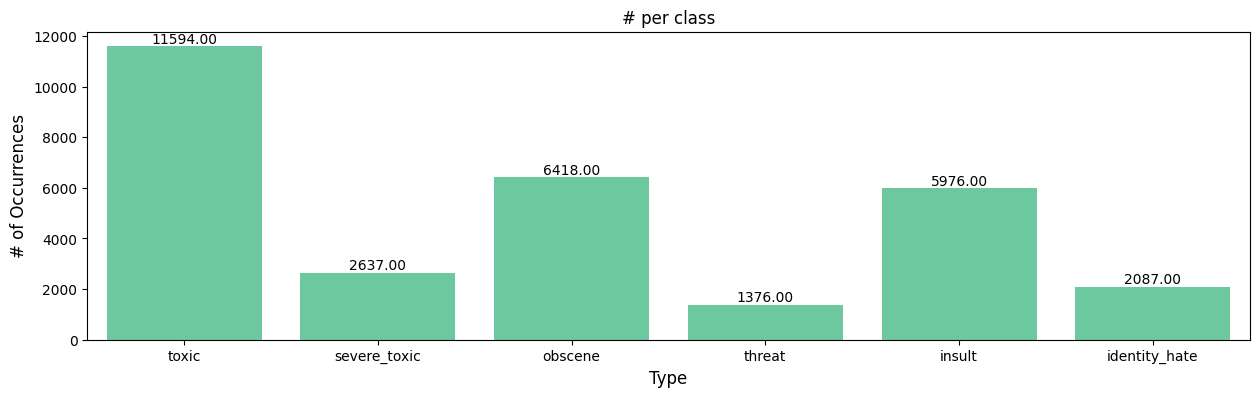

In [ ]:
target_y =train_dataset.iloc[:,1:].sum()
weights_list = target_y.tolist()
weights = torch.tensor(weights_list, dtype=torch.float32)
normalized_weights = weights / weights.sum()
print(normalized_weights)

print(f"total samples {train_dataset.shape[0]}")
proportion_balance_classes(target_y.index, target_y.values)

We reduced the dataset size from 100k to 26k, removing a significant number of rows. This reduction allows the model to improve both in terms of training time and performance.

<ipython-input-9-59575d70403b>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for better visibility
<ipython-input-9-59575d70403b>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for better visibility
<ipython-input-9-59575d70403b>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for better visibility


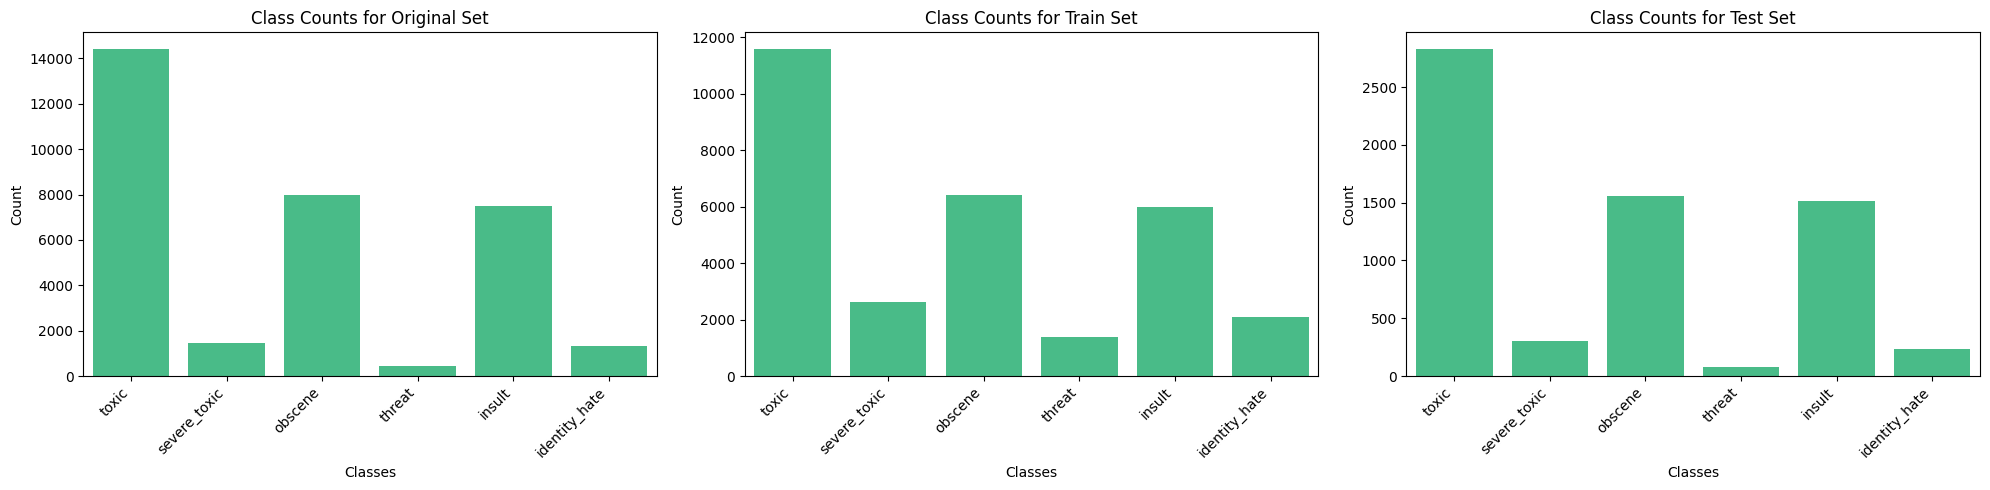

In [ ]:
# Summing over each column to count occurrences of each class in each dataset
all_counts_dfs = pd.DataFrame({
    'Original Set': dataframe_clean[attributes].sum(),
    'Train Set': train_dataset[attributes].sum(),
    'Test Set': validation_dataset[attributes].sum()
})

# Plot setup
fig, axes = plt.subplots(nrows=1, ncols=len(all_counts_dfs.columns), figsize=(20, 5))

# Iterate over the columns to create a bar chart for each dataset
for ax, column in zip(axes, all_counts_dfs.columns):
    sns.barplot(x=all_counts_dfs.index, y=all_counts_dfs[column], ax=ax)
    ax.set_title(f'Class Counts for {column}')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")  # Rotate x labels for better visibility

# Adjust layout
plt.tight_layout()
plt.show()

# Create a dataset

We will be preparing the dataset for the importation!

In [ ]:
#@title custom dataset import class
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, comment_str_title: str,  tokenizer, attributes, max_token_len= 128, sample= None):

        assert isinstance(dataframe, pd.DataFrame), "dataframe needs to be a pandas DataFrame for this code to work"

        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.attributes = attributes
        self.sample = sample
        self._prepare_data()

        # column to select
        self.comment_str_title = comment_str_title

    def _prepare_data(self):
        """Prepare the data and imported"""
        # data = pd.read_csv(self.data_path)
        data = self.dataframe.copy()
        # add the non toxic column
        data["non_toxic"] = np.where(data[attributes].any(axis=1), 0, 1)
        # data["unhealthy"] = np.where(data["healthy"] == 1, 0, 1)

        # extract the sample with some attributes
        if self.sample is not None:
            toxic = data.loc[data[self.attributes].sum(axis=1) > 0]
            non_toxic = data.loc[data[self.attributes].sum(axis=1) == 0]
            # extract the sample from the healthy values
            non_toxic = non_toxic.sample(min(self.sample, len(non_toxic)), random_state=7)
            self.data = pd.concat([non_toxic, toxic])
        else:
            self.data = data

    def __len__(self):
        """Length of the dataset"""
        return (len(self.data))

    def __getitem__(self, index):
        """Get item from the dataset"""
        data_row = self.data.iloc[index]

        # item as a string
        comment = str(data_row[self.comment_str_title])
        # attributes_numbers = torch.FloatTensor(data_row.iloc[self.attributes])
        attributes_numbers = torch.FloatTensor(data_row[self.attributes].values.astype(float))

        # extract the tokens and prepared to apply it to the comment line
        tokens = self.tokenizer.encode_plus(
                    comment,
                    add_special_tokens = True,
                    max_length = self.max_token_len,
                    padding = 'max_length',
                    truncation = True, # cap the comments to a max length of tokens
                    return_tensors = 'pt', # return tensors
                    return_attention_mask = True,
                    return_token_type_ids = False, # this its not need it
                    )

        return {'input_id': tokens.input_ids.flatten(),
                'attention_mask': tokens.attention_mask.flatten(),
                'labels': attributes_numbers,
                'labels_names': self.attributes}


In this case, we will not use any sampling for evaluating the model's performance in this experiment.

In [ ]:
model_name = 'roberta-base' #@param
tokenizer_roberta = AutoTokenizer.from_pretrained(model_name)
dataset_loader = CustomDataset(
    dataframe= train_dataset,
    comment_str_title = 'comment_text', #@param
    attributes = attributes,
    tokenizer = tokenizer_roberta,
    max_token_len = 256, #@param
    sample=None#@param
    )


# data_path, comment_str_title: str,  tokenizer, attributes, max_token_len= 128, sample= 5000
print(dataset_loader.__len__())
dataset_loader

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

27357


Now we could see that we had 29k of samples for training the model the double of samples that are not

In [ ]:
dataset_loader.__getitem__(0)

{'input_id': tensor([    0,  3084,     6,    24,    21,  4979,    12, 37705,  7586,    45,
          1166,    19,    80,   385,    18,  7586,    47,  4062,  9673,  2688,
         46997,  1862,   230,  4154,   565, 32376,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,    

Seems that one example its working correctly

# Data loader

In [ ]:
#@title Custom class data loader
class Data_loader_Custom(pl.LightningDataModule):
    def __init__(self, train_dataframe, val_dataframe , attributes, comment_str_title: str, tokenizer,model_name = 'roberta-base',   batch_size= 16, max_token_len= 128 , sample= None, num_workers= 4, prediction_count = False):
        super().__init__()
        self.train_dataframe = train_dataframe
        self.val_dataframe = val_dataframe
        self.batch_size = batch_size
        self.max_token_len = max_token_len
        self.comment_str_title = comment_str_title
        self.attributes = attributes
        self.sample = sample
        self.num_workers = num_workers
        self.tokenizer = tokenizer
        self.model_name = model_name
        self.prediction_count = prediction_count

        # check if exist
        self.has_train_data = train_dataframe is not None
        self.has_val_data = val_dataframe is not None

    def __len__(self):
        if self.has_train_data:
            return len(self.train_dataset)
        if self.has_val_data:
            return len(self.validation_dataset)

    def len_predictions(self):
        if self.has_val_data:
            return len(self.validation_dataset)

    # this its using the LightningDataModule for seting up
    def setup(self, stage= None):
        if stage in (None, 'fit'):
            # train set
            self.train_dataset = CustomDataset(
                                dataframe=  self.train_dataframe,
                                comment_str_title =  self.comment_str_title,
                                attributes =  self.attributes,
                                tokenizer =  self.tokenizer,
                                max_token_len =  self.max_token_len,
                                sample= self.sample)
            # validation set
            self.validation_dataset = CustomDataset(
                                dataframe=  self.val_dataframe,
                                comment_str_title =  self.comment_str_title,
                                attributes =  self.attributes,
                                tokenizer =  self.tokenizer,
                                max_token_len =  self.max_token_len,
                                sample= self.sample)
        if stage == 'predict':
            self.predict_dataset  = CustomDataset(
                                dataframe=  self.val_dataframe,
                                comment_str_title =  self.comment_str_title,
                                attributes =  self.attributes,
                                tokenizer =  self.tokenizer,
                                max_token_len =  self.max_token_len,
                                sample= self.sample)

    # dataload the the different sets
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=  self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.validation_dataset, batch_size=self.batch_size, num_workers= self.num_workers, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, batch_size=self.batch_size, num_workers= self.num_workers, shuffle=False)


Verify it works

In [ ]:
#@title Object creation
data_module_custom = Data_loader_Custom(
                   train_dataframe = train_dataset,
                   val_dataframe = validation_dataset,
                   attributes = attributes,
                   comment_str_title = 'comment_text',
                   tokenizer = AutoTokenizer.from_pretrained('roberta-base'),
                   batch_size= 8, #@param
                   max_token_len= 128 , #@param
                   sample= None, #@param
                   num_workers= 2,
                   prediction_count= False)

# setup the data in dataloaders
data_module_custom.setup()
print(len(data_module_custom))
print(data_module_custom.len_predictions())
# prepare the data batches
dl = data_module_custom.train_dataloader()
print(f"batches train:{len(dl)}")
dl = data_module_custom.val_dataloader()
print(f"batches train:{len(dl)}")

# we enalbe the prediction so we can see the values of precit
data_module_custom.setup(stage='predict')
dl = data_module_custom.predict_dataloader()
print(f"batches train:{len(dl)}")

27357
28958
batches train:3420
batches train:3620
batches train:3620


Now that we had the custom batch prepared, we will start with the model creation.

----------

# Model creation

In [ ]:
class Classifier_model(pl.LightningModule):
    def __init__(self, config: dict):
        super().__init__()
        self.config = config

        # pretrain the model
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)

        # add the other layers of the model
        self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classification = nn.Linear(self.pretrained_model.config.hidden_size, self.config["n_labels"])

        # initializing weights in a layer, you apply it directly to the weight tensor
        torch.nn.init.xavier_normal_(self.hidden.weight)
        torch.nn.init.xavier_normal_(self.classification.weight)

        # loss function for mote then 1 label
        self.loss_function = nn.BCEWithLogitsLoss(weight=normalized_weights, reduction='mean')
        self.dropout = nn.Dropout(config["dropout_vals"])

        # results in a list
        self.results_training = []
        self.results_validation = []

    # forward pass
    def forward(self, input_ids, attention_mask, labels = None):
        output = self.pretrained_model(input_ids= input_ids, attention_mask = attention_mask)

        # apply max pooling
        pooled_out = torch.mean(output.last_hidden_state, 1)

        # pass to the layers we create
        pooled_output = self.hidden(pooled_out)
        pooled_output = self.dropout(pooled_output)
        pooled_output = F.relu(pooled_output)
        logits = self.classification(pooled_output)

        # calculate the loss
        loss = 0
        if labels is not None:
            loss = self.loss_function(logits.view(-1, self.config["n_labels"]), # extract predictions
                                      labels.view(-1, self.config["n_labels"])) # extract labels
        return loss, logits

    """ compute the metrics"""
    def compute_metrics(self, logits, labels):
        # Convert logits to predictions (using sigmoid for multi-label classification)
        preds = torch.sigmoid(logits) > 0.5
        labels = labels.cpu().numpy()  # Convert to numpy for sklearn functions
        preds = preds.cpu().numpy()

        # Compute accuracy and recall
        accuracy = accuracy_score(labels.flatten(), preds.flatten())  # Flatten the arrays
        # recall = recall_score(labels.flatten(), preds.flatten(), average='macro')  # Compute recall
        recall = recall_score(labels.flatten(), preds.flatten(), average='weighted', zero_division=0)


        return accuracy, recall

    # training, validation and test step
    def training_step(self, batch, batch_index):
        loss, logits = self(batch['input_id'], batch['attention_mask'], batch['labels'])
        train_accuracy, train_recall = self.compute_metrics(logits, batch['labels'])

        # append to results
        self.results_training.append({
            "epoch": self.current_epoch,
            "batch_train": batch_index,
            "train_loss": loss.item(),
            "train_accuracy": train_accuracy,
            "train_recall": train_recall,
        })

        # Log the loss, accuracy, and recall during training
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", train_accuracy, prog_bar=True, logger=True)
        self.log("train_recall", train_recall, prog_bar=True, logger=True)

        return {"loss": loss, "predictions_logits": logits, "labels": batch["labels"]}

    def validation_step(self, batch, batch_index):
        loss, logits = self(batch['input_id'], batch['attention_mask'], batch['labels'])
        valid_accuracy, valid_recall = self.compute_metrics(logits, batch['labels'])

        self.results_validation.append({
            "epoch": self.current_epoch,
            "batch_val": batch_index,
            "valid_loss": loss.item(),
            "valid_accuracy": valid_accuracy,
            "valid_recall": valid_recall,
        })

        # Log the loss, accuracy, and recall during validation
        self.log("valid_loss", loss, prog_bar=True, logger=True)
        self.log("valid_accuracy", valid_accuracy, prog_bar=True, logger=True)
        self.log("valid_recall", valid_recall, prog_bar=True, logger=True)


        return {"validation_loss": loss, "predictions_logits": logits, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        _, logits = self(batch['input_id'], batch['attention_mask'], batch['labels'])
        return logits

    # setup the optimizer
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr= self.config["lr"], weight_decay = self.config["w_decay"])
        # scheduler for the optimizer
        total_steps = self.config["train_size"] / self.config["batch_size"]
        warmup_steps = math.floor(total_steps * self.config["warmup"])

        # prepare the schedulers
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

        return [optimizer], [scheduler]

Verify if it works

In [ ]:
config ={
    "model_name": 'roberta-base',
    "n_labels": len(attributes),
    "batch_size": 128,
    "lr": 1.5e-6,
    "warmup": 0.2,
    "train_size": len(data_module_custom.train_dataloader()),
    "w_decay": 0.001,
    "n_epochs": 100,
    "dropout_vals": 0.2
}

model_roberta = Classifier_model(config)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# index value
idx = 2

# extract the values
input_ids = dataset_loader.__getitem__(idx)['input_id']
attention_mask = dataset_loader.__getitem__(idx)['attention_mask']
labels = dataset_loader.__getitem__(idx)['labels']
labels_names = dataset_loader.__getitem__(idx)['labels_names']

loss, output = model_roberta(input_ids.unsqueeze(dim=0),
                     attention_mask.unsqueeze(dim=0),
                     labels.unsqueeze(dim=0))

print("===================")
print(loss)
print(output)
print("===================")
print(labels_names)
print(labels)

tensor(0.1111, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor([[-0.1028,  0.2529,  0.3501, -0.0902,  0.1466, -0.2627]],
       grad_fn=<AddmmBackward0>)
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
tensor([1., 0., 1., 0., 1., 0.])


### another example

In [ ]:
# this its the index
input_text = dataframe_test.iloc[24]["comment_text"]

tokenizer_roberta_prediction = AutoTokenizer.from_pretrained(model_name)
inputs_tokens = tokenizer_roberta_prediction.encode_plus(
                                            input_text,
                                            add_special_tokens = True,
                                            max_length = 256,
                                            padding = 'max_length',
                                            truncation = True, # cap the comments to a max length of tokens
                                            return_tensors = 'pt', # return tensors
                                            return_attention_mask = True,
                                            return_token_type_ids = False, # this its not need it
                                            )

# Extract input_ids and attention_mask from tokenized input
input_ids = inputs_tokens["input_ids"]
attention_mask = inputs_tokens["attention_mask"]

# Set the model to evaluation mode (disable dropout)
model_roberta.eval()

# Make predictions without gradients
with torch.no_grad():
    _, logits = model_roberta(input_ids=input_ids, attention_mask=attention_mask)

# Apply sigmoid activation to logits to get probabilities for each label
probs = torch.sigmoid(logits).squeeze().cpu().numpy()
threshold = 0.5
predicted_labels = [attributes[i] for i, p in enumerate(probs) if p >= threshold]

print("this its the comment:")
print(input_text)
print("--------------------------------")
print("Column names:", attributes)
print("Probabilities:", probs)
print("--------------------------------")
print("predicted_labels:", predicted_labels)

dataframe_test[dataframe_test["toxic"] == 1].head(2)

this its the comment:
DJ Robinson is gay as hell! he sucks his dick so much!!!!!
--------------------------------
Column names: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Probabilities: [0.6084442  0.60796    0.50242966 0.41079935 0.44862425 0.513701  ]
--------------------------------
predicted_labels: ['toxic', 'severe_toxic', 'obscene', 'identity_hate']


,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
8,1,0,0,0,0,0,"== Arabs are committing genocide in Iraq, but ..."
24,1,0,1,0,1,1,DJ Robinson is gay as hell! he sucks his dick ...


Seems that its making the predictions correctly but because the model its only train with some examples we need to verify it again and trained longer

# Train the model

In this case, we will be running the model for additional epochs to assess if this leads to an improvement in performance.

In [ ]:
#@title parameters of the model
# model name from hugging face
model_name = 'roberta-base' #@param
value_batch_size =16 #@param
value_learning_rate = 2.057626963810742e-06 #@param
value_warmup = 0.2410014240231825 #@param
value_w_decay = 8.747541196471078e-09 #@param
value_n_epochs = 4  #@param
value_dropout = 0.3789390401864389 #@param

config ={
    "model_name": model_name,
    "n_labels": len(attributes),
    "batch_size": value_batch_size,
    "lr": value_learning_rate,
    "warmup": value_warmup,
    "train_size": len(data_module_custom.train_dataloader()),
    "w_decay": value_w_decay,
    "n_epochs": value_n_epochs,
    "dropout_vals": value_dropout
}


# load the dataset
data_module_custom = Data_loader_Custom(
                   train_dataframe = train_dataset,
                   val_dataframe = validation_dataset,
                   attributes = attributes,
                   comment_str_title = 'comment_text',
                   tokenizer = AutoTokenizer.from_pretrained('roberta-base'),
                   batch_size= config["batch_size"],
                   max_token_len= 256 ,
                   sample= None,
                   num_workers= num_workers_colab,
                   prediction_count= False)
data_module_custom.setup()

# model
model_roberta = Classifier_model(config)

# train the model
trainer = pl.Trainer(max_epochs = config["n_epochs"],
                     accelerator="gpu",
                     devices= num_gpus_colab,
                     num_sanity_val_steps=50,
                     check_val_every_n_epoch=1)

trainer.fit(model_roberta, data_module_custom)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type              | Params | Mode 
---------------------------------------------------------------
0 | pretrained_model | RobertaModel      | 124 M  | eval 
1 | hidden           | Linear            | 590 K  | train
2 | classification   | Linear            | 4.6 K  | train
3 | loss_function    | BCEWithLogitsL

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 14. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.


The results are promising, showing strong accuracy and recall. However, a deeper analysis is needed to fully understand the underlying performance and identify any areas for improvement.

In [ ]:
# prepare the dataset
results_df_training = pd.DataFrame(model_roberta.results_training)
results_df_validation = pd.DataFrame(model_roberta.results_validation)
results_df_training = results_df_training.rename(columns={"batch_train": "batch"})
results_df_validation = results_df_validation.rename(columns={"batch_val": "batch"})
results_df = results_df_training.merge(results_df_validation, on=["batch", "epoch"])
results_df = results_df.drop_duplicates().reset_index(drop=True)
results_df['epoch_batch'] = results_df['epoch'].astype(str) + "-" + results_df['batch'].astype(str)
results_df.tail()

,epoch,batch,train_loss,train_accuracy,train_recall,valid_loss,valid_accuracy,valid_recall,epoch_batch
6835,3,1705,0.049835,0.895833,0.895833,0.029512,0.979167,0.979167,3-1705
6836,3,1706,0.077244,0.812500,0.812500,0.030255,0.979167,0.979167,3-1706
6837,3,1707,0.075376,0.822917,0.822917,0.051551,0.927083,0.927083,3-1707
6838,3,1708,0.061210,0.875000,0.875000,0.018265,0.989583,0.989583,3-1708
6839,3,1709,0.070630,0.871795,0.871795,0.021978,0.979167,0.979167,3-1709


The initial results appear promising, but a more detailed review of each category is necessary to ensure the model performs correctly across all aspects.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

<IPython.core.display.Javascript object>

We observed a decrease in the loss functions and various metrics, but we need to validate the model to ensure it is not overfitting.

In [ ]:
fig = make_subplots(rows=3, cols=1, subplot_titles=("Loss", "Accuracy", "Recall"))

# Plot Loss for Training and Validation
fig.add_trace(
    go.Scatter(x=results_df['epoch_batch'], y=results_df['train_loss'], mode='lines+markers', name="Train Loss"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=results_df['epoch_batch'], y=results_df['valid_loss'], mode='lines+markers', name="Val Loss"),
    row=1, col=1
)
fig.update_xaxes(title_text="Epoch-Batch", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=1)

# Plot Accuracy for Training and Validation
fig.add_trace(
    go.Scatter(x=results_df['epoch_batch'], y=results_df['train_accuracy'], mode='lines+markers', name="Train Accuracy"),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=results_df['epoch_batch'], y=results_df['valid_accuracy'], mode='lines+markers', name="Val Accuracy"),
    row=2, col=1
)
fig.update_xaxes(title_text="Epoch-Batch", row=2, col=1)
fig.update_yaxes(title_text="Accuracy", row=2, col=1)

# Plot Recall for Training and Validation
fig.add_trace(
    go.Scatter(x=results_df['epoch_batch'], y=results_df['train_recall'], mode='lines+markers', name="Train Recall"),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=results_df['epoch_batch'], y=results_df['valid_recall'], mode='lines+markers', name="Val Recall"),
    row=3, col=1
)
fig.update_xaxes(title_text="Epoch-Batch", row=3, col=1)
fig.update_yaxes(title_text="Recall", row=3, col=1)

# Update layout
fig.update_layout(
    title_text="Training and Validation Metrics by Epoch-Batch",
    height=1200,
    showlegend=True
)

# Show the plot
fig.show()

In [ ]:
fig = make_subplots(rows=3, cols=1, subplot_titles=("Loss", "Accuracy", "Recall"))

# Plot Loss for Training and Validation
fig.add_trace(
    go.Scatter(x=results_df['epoch'], y=results_df['train_loss'], mode='lines+markers', name="Train Loss"),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=results_df['epoch'], y=results_df['valid_loss'], mode='lines+markers', name="Val Loss"),
    row=1, col=1
)
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=1)

# Plot Accuracy for Training and Validation
fig.add_trace(
    go.Scatter(x=results_df['epoch'], y=results_df['train_accuracy'], mode='lines+markers', name="Train Accuracy"),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=results_df['epoch'], y=results_df['valid_accuracy'], mode='lines+markers', name="Val Accuracy"),
    row=2, col=1
)
fig.update_xaxes(title_text="Epoch", row=2, col=1)
fig.update_yaxes(title_text="Accuracy", row=2, col=1)

# Plot Recall for Training and Validation
fig.add_trace(
    go.Scatter(x=results_df['epoch'], y=results_df['train_recall'], mode='lines+markers', name="Train Recall"),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=results_df['epoch'], y=results_df['valid_recall'], mode='lines+markers', name="Val Recall"),
    row=3, col=1
)
fig.update_xaxes(title_text="Epoch", row=3, col=1)
fig.update_yaxes(title_text="Recall", row=3, col=1)

# Update layout
fig.update_layout(
    title_text="Training and Validation Metrics by Epoch",
    height=1200,
    showlegend=True
)

# Show the plot
fig.show()


We observed that after the third epoch, the model maintains consistently high values, which makes the predictions appear promising.

# Predict the model
we will be predicting the values using the model

In [ ]:
def classify_raw_comments(model, dataset_loader_class):
    predictions = trainer.predict(model, dataset_loader_class.predict_dataloader())
    print(len(predictions))
    all_predictions = []
    for batch in predictions:
        batch_predictions = [torch.sigmoid(torch.Tensor(p)).numpy() for p in batch]
        all_predictions.extend(batch_predictions)
    flatten_predictions = np.stack(all_predictions)
    print(flatten_predictions.shape)
    print(len(all_predictions))
    return flatten_predictions


# enable predictions
data_module_custom.setup(stage='predict')
# the dataloader come from this class ==> CustomDataset
predictions_object = classify_raw_comments(model_roberta, data_module_custom)
predictions_object.shape

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

1810
(28958, 6)
28958


(28958, 6)

In [ ]:
true_labels = np.array(validation_dataset[attributes].values)
print(len(true_labels))
true_labels

28958


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

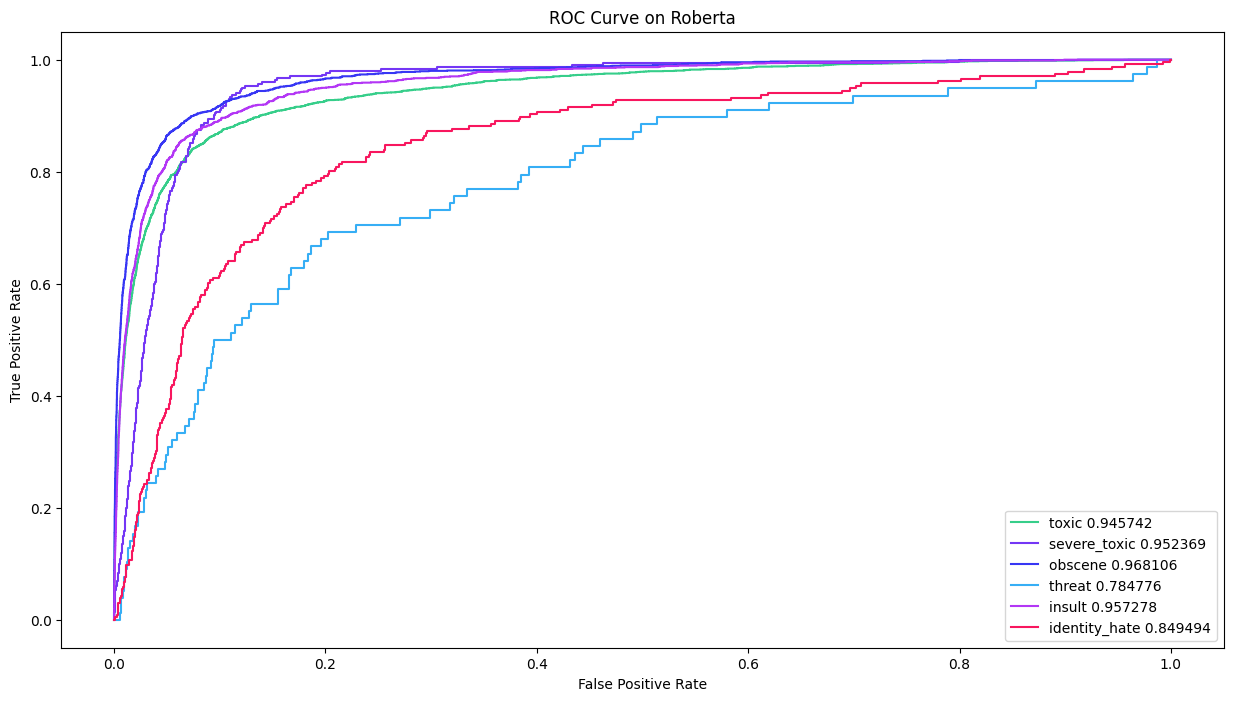

In [ ]:
plt.figure(figsize=(15,8))
for i, attribute in enumerate(attributes):
    fpr, tpr, thresholds = metrics.roc_curve(true_labels[:, i].astype(int), predictions_object[:, i])
    auc = metrics.roc_auc_score(true_labels[:, i].astype(int), predictions_object[:, i])
    plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Roberta')
plt.legend(loc = "lower right")
plt.show()


The "threat" category seems to be facing challenges with predictions. While the predictability of threats performed better compared to the previous model, showing an 8% improvement, the "identity hate" category experienced a significant decline in performance, with a 10% reduction.

In [ ]:
data_module_predictions = Data_loader_Custom(
                   train_dataframe = train_dataset,
                   val_dataframe = dataframe_test,
                   attributes = attributes,
                   comment_str_title = 'comment_text',
                   tokenizer = AutoTokenizer.from_pretrained('roberta-base'),
                   batch_size= 8,
                   max_token_len= 128 ,
                   sample= None,
                   num_workers= 2,
                   prediction_count= False)

data_module_predictions.setup(stage='predict')
predictions_object = classify_raw_comments(model_roberta, data_module_predictions)
predictions_object.shape

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

7998
(63978, 6)
63978


(63978, 6)

In [ ]:
predictions_object

array([[0.03936893, 0.13108447, 0.04562778, 0.06968293, 0.05267286,
        0.07039542],
       [0.86118937, 0.1660128 , 0.4320781 , 0.07937668, 0.25423273,
        0.0768552 ],
       [0.40271384, 0.1497522 , 0.21283562, 0.14388461, 0.19189051,
        0.15748774],
       ...,
       [0.62722903, 0.07045494, 0.16857338, 0.07501341, 0.20225558,
        0.03478926],
       [0.7463653 , 0.1906379 , 0.5557989 , 0.32160783, 0.4426794 ,
        0.26290634],
       [0.19112952, 0.09389464, 0.08389085, 0.12774944, 0.06847381,
        0.07810871]], dtype=float32)

In [ ]:
true_labels = np.array(dataframe_test[attributes].values)
print(len(true_labels))
true_labels

63978


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

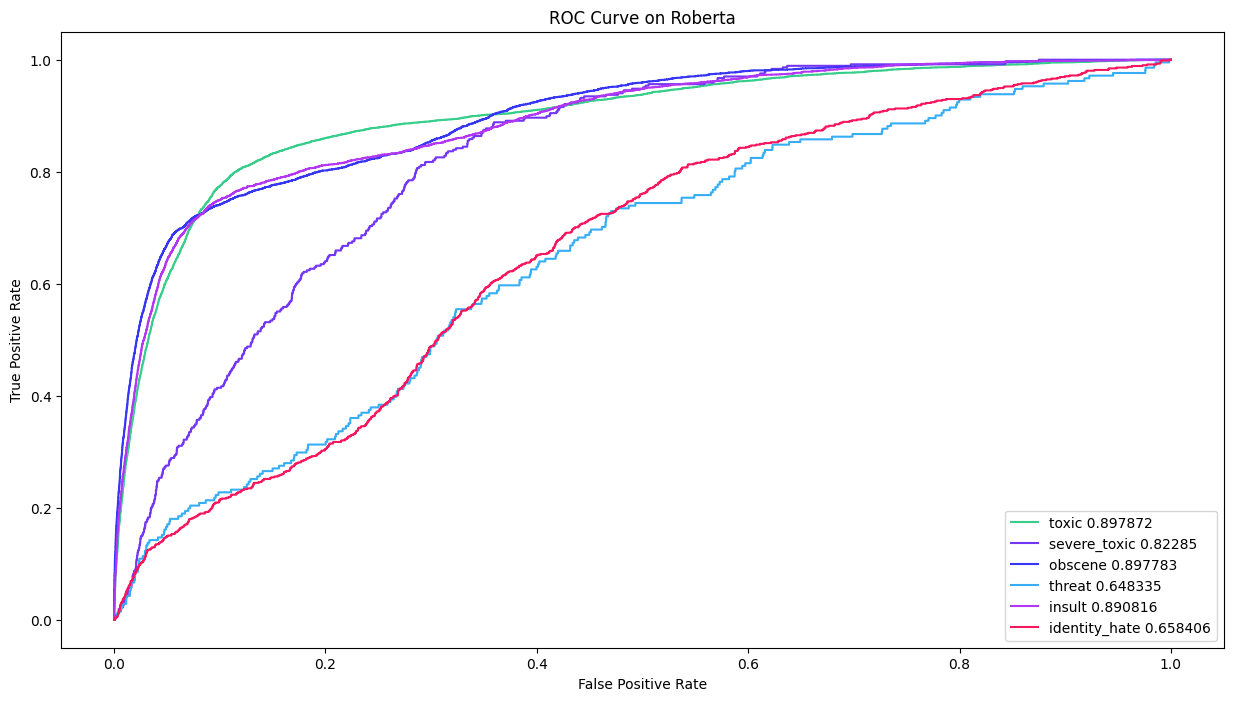

In [ ]:
plt.figure(figsize=(15,8))
for i, attribute in enumerate(attributes):
    fpr, tpr, thresholds = metrics.roc_curve(true_labels[:, i].astype(int), predictions_object[:, i])
    auc = metrics.roc_auc_score(true_labels[:, i].astype(int), predictions_object[:, i])

    # plt.plot(fpr, tpr, label=f' %s  %g {attribute} (AUC = {auc:.2f})')
    plt.plot(fpr, tpr, label='%s %g' % (attribute, auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Roberta')
plt.legend(loc = "lower right")
plt.show()


The model shows worse performance in the generalized classes overall, despite an improvement in the "threat" category. However, the "identity hate" category performed poorly in predictions. Given these results, it doesn’t make sense to continue using this model.

# Save the model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoConfig
import os

# Save the entire model (including weights and custom layers)
torch.save(model_roberta.state_dict(), os.path.join(URL_model_saved, "model_017.pth"))

# Save the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(URL_model_saved)

# Save the config properly (ensure it's a PretrainedConfig object)
model_config = model_roberta.pretrained_model.config
model_config.save_pretrained(URL_model_saved)

print(f"Model and tokenizer saved to {URL_model_saved}")


Model and tokenizer saved to /content/drive/MyDrive/Code/Data_science_Turing_college/Colabs/14_002_NLP/model/017_model


# load pretrained model

In [ ]:
class Classifier_model_loader(nn.Module):
    def __init__(self, config: dict, loss_function=None):
        super().__init__()
        self.config = config
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)
        self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classification = nn.Linear(self.pretrained_model.config.hidden_size, self.config["n_labels"])
        self.dropout = nn.Dropout(config["dropout_vals"])

        # Use provided loss function, or default to BCEWithLogitsLoss
        if loss_function is None:
            self.loss_function = nn.BCEWithLogitsLoss(reduction='mean')
        else:
            self.loss_function = loss_function

    def forward(self, input_ids, attention_mask):
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_out = torch.mean(output.last_hidden_state, 1)
        pooled_output = self.hidden(pooled_out)
        pooled_output = self.dropout(pooled_output)
        pooled_output = torch.relu(pooled_output)
        logits = self.classification(pooled_output)

        return logits

    def compute_loss(self, predictions, targets):
        return self.loss_function(predictions, targets)



# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(URL_model_saved)

initiate_config = {'model_name': 'roberta-base',
                    'n_labels': 6,
                    'batch_size': 8,
                    'lr': 1.5e-06,
                    'warmup': 0.2,
                    'train_size': 3346,
                    'w_decay': 0.001,
                    'n_epochs': 1,
                    'dropout_vals': 0.2}


# Initialize the model with the same configuration
model_import = Classifier_model_loader(initiate_config,
                                       loss_function=nn.BCEWithLogitsLoss(weight=normalized_weights))

# Load the state dict (this includes pretrained weights and custom layers)
model_import.load_state_dict(torch.load(os.path.join(URL_model_saved, "model_017.pth")))

print("Model loaded successfully!")
model_import

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-37-dfa815c4ff0e>:50: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We reco

Model loaded successfully!


Classifier_model_loader(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

# We will make a prediction

using the loader file and the actual model

In [ ]:
# this its the index
input_text = dataframe_test.iloc[24]["comment_text"]

tokenizer_roberta_prediction = AutoTokenizer.from_pretrained(model_name)
inputs_tokens = tokenizer_roberta_prediction.encode_plus(
                                            input_text,
                                            add_special_tokens = True,
                                            max_length = 256,
                                            padding = 'max_length',
                                            truncation = True, # cap the comments to a max length of tokens
                                            return_tensors = 'pt', # return tensors
                                            return_attention_mask = True,
                                            return_token_type_ids = False, # this its not need it
                                            )

# Extract input_ids and attention_mask from tokenized input
input_ids = inputs_tokens["input_ids"]
attention_mask = inputs_tokens["attention_mask"]

# Set the model to evaluation mode (disable dropout)
model_import.eval()

# Make predictions without gradients
with torch.no_grad():
    logits = model_import(input_ids=input_ids, attention_mask=attention_mask)

# Apply sigmoid activation to logits to get probabilities for each label
probs = torch.sigmoid(logits).squeeze().cpu().numpy()
threshold = 0.5
predicted_labels = [attributes[i] for i, p in enumerate(probs) if p >= threshold]

print("this its the comment:")
print(input_text)
print("--------------------------------")
print("Column names:", attributes)
print("Probabilities:", probs)
print("--------------------------------")
print("predicted_labels:", predicted_labels)

dataframe_test[dataframe_test["toxic"] == 1].head(2)

this its the comment:
DJ Robinson is gay as hell! he sucks his dick so much!!!!!
--------------------------------
Column names: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Probabilities: [0.94088703 0.24572854 0.6803261  0.17745449 0.5787394  0.14366412]
--------------------------------
predicted_labels: ['toxic', 'obscene', 'insult']


,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
8,1,0,0,0,0,0,"== Arabs are committing genocide in Iraq, but ..."
24,1,0,1,0,1,1,DJ Robinson is gay as hell! he sucks his dick ...


In this case, the model does nor predict the identity hate categorie

In [ ]:
# this its the index
input_text = dataframe_test.iloc[38]["comment_text"]

tokenizer_roberta_prediction = AutoTokenizer.from_pretrained(model_name)
inputs_tokens = tokenizer_roberta_prediction.encode_plus(
                                            input_text,
                                            add_special_tokens = True,
                                            max_length = 256,
                                            padding = 'max_length',
                                            truncation = True, # cap the comments to a max length of tokens
                                            return_tensors = 'pt', # return tensors
                                            return_attention_mask = True,
                                            return_token_type_ids = False, # this its not need it
                                            )

# Extract input_ids and attention_mask from tokenized input
input_ids = inputs_tokens["input_ids"]
attention_mask = inputs_tokens["attention_mask"]

# Set the model to evaluation mode (disable dropout)
model_import.eval()

# Make predictions without gradients
with torch.no_grad():
    logits = model_import(input_ids=input_ids, attention_mask=attention_mask)

# Apply sigmoid activation to logits to get probabilities for each label
probs = torch.sigmoid(logits).squeeze().cpu().numpy()
threshold = 0.5
predicted_labels = [attributes[i] for i, p in enumerate(probs) if p >= threshold]

print("this its the comment:")
print(input_text)
print("--------------------------------")
print("Column names:", attributes)
print("Probabilities:", probs)
print("--------------------------------")
print("predicted_labels:", predicted_labels)

dataframe_test[dataframe_test["toxic"] == 1].head(10)

this its the comment:
How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!
--------------------------------
Column names: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
Probabilities: [0.1626426  0.07487608 0.04471726 0.11554734 0.09620273 0.05307002]
--------------------------------
predicted_labels: []


,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
8,1,0,0,0,0,0,"== Arabs are committing genocide in Iraq, but ..."
24,1,0,1,0,1,1,DJ Robinson is gay as hell! he sucks his dick ...
29,1,0,1,0,1,0,":Fuck off, you anti-semitic cunt. |"
38,1,0,0,0,0,0,How dare you vandalize that page about the HMS...
40,1,0,1,0,1,0,"::No, he is an arrogant, self serving, immatur..."
89,1,0,0,0,0,0,":Eek, but shes cute in an earthy kind of way. ..."
106,1,0,1,0,0,0,"::::Well, it sucks to have a university to be ..."
107,1,0,1,0,1,0,== Argh == \n\n Some random idiot deleted the ...
124,1,0,1,1,0,0,(we hate america and we are going to bomb the ...
125,1,0,1,0,1,0,== Bold textYOU SUCK!!! == \n\n \n\n U SUCK H...


In this case seems that the model its not predict anything so its not working fine.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Threshold the predictions
threshold = 0.50
predicted_labels = (predictions_object >= threshold).astype(int)

# Flatten the arrays for the confusion matrix
flattened_predictions = predicted_labels.flatten()
flattened_true_labels = true_labels.flatten()

# Compute the confusion matrix
conf_matrix = confusion_matrix(flattened_true_labels, flattened_predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print additional metrics
print("\nClassification Report:")
print(classification_report(flattened_true_labels, flattened_predictions))


Confusion Matrix:
[[360792   8578]
 [  6879   7619]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    369370
           1       0.47      0.53      0.50     14498

    accuracy                           0.96    383868
   macro avg       0.73      0.75      0.74    383868
weighted avg       0.96      0.96      0.96    383868



We had a reduction of more then 10% in recall that its our objective, so seems that the model its not performing correctly, so need to adjust the therholds maybe in that way we can increase the perfromance.

In [ ]:
# Convert predictions to binary based on threshold 0.50
predictions_binary = (predictions_object >= 0.50).astype(int)
confusion_matrices = []

# Compute confusion matrix for each class (columns of the matrix)
num_classes = true_labels.shape[1]
for i in range(num_classes):
    true_class = true_labels[:, i]
    pred_class = predictions_binary[:, i]
    cm = confusion_matrix(true_class, pred_class)
    confusion_matrices.append(cm)

# Print the confusion matrix for each class
for i, cm in enumerate(confusion_matrices):
    attribute_name = attributes[i]
    print(f"Confusion matrix for class {attribute_name}:")
    print(cm)
    print()


Confusion matrix for class toxic:
[[51216  6672]
 [ 1217  4873]]

Confusion matrix for class severe_toxic:
[[63611     0]
 [  367     0]]

Confusion matrix for class obscene:
[[59235  1052]
 [ 2000  1691]]

Confusion matrix for class threat:
[[63634   133]
 [  210     1]]

Confusion matrix for class insult:
[[59831   720]
 [ 2373  1054]]

Confusion matrix for class identity_hate:
[[63265     1]
 [  712     0]]



Here’s an extended and detailed synthesis approach for generating more diverse and realistic synthetic data, targeting underrepresented classes like identity_hate, threat, and severe_toxic.

### Summary

We tested the model with synthetic data, but it did not perform as expected. There was no noticeable improvement in the model's performance. An alternative approach could be to enhance the results by adjusting the threshold.
